**Author:** Boris Kundu

**Problem Statement:** Comparing Linear Regression, RNN, LSTM and GRU models on Time-Series data

**Dataset:** COVID-19 hospitalizations

In [224]:
#Import packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

In [225]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [226]:
#Standardize data
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

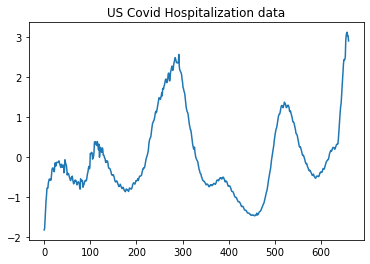

In [227]:
#Plot data
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [228]:
#Parameters
last = len(hosp) #Total data points
seqlen = 20 # input size or window size
batchsize = 50 # data period and number of data points
trainbegin = np.random.randint(400) #Get random start day for training
epochs = 1000

In [229]:
#Preparing training data
Xtrain = np.array(hosp[trainbegin:trainbegin+seqlen])
ytrain = np.array(hosp[trainbegin+seqlen])
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [230]:
#TYrainb linear regression model
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
ypred = lin_reg.predict(Xtrain)
print('LinearRegression MSE:', mean_squared_error(ytrain, ypred))

LinearRegression MSE: 0.003752049591056762


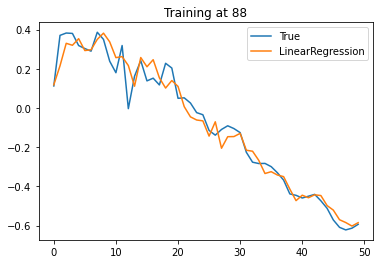

In [231]:
plt.plot(ytrain)
plt.plot(ypred)
plt.legend(['True','LinearRegression'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [232]:
lin_reg = SGDRegressor()
lin_reg.fit(Xtrain, ytrain)
ySGD = lin_reg.predict(Xtrain)
print('SGDRegressor MSE:', mean_squared_error(ytrain, ySGD))

SGDRegressor MSE: 0.014290984311032824


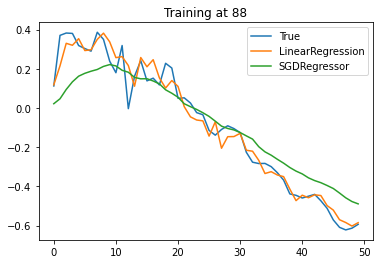

In [233]:
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(ySGD)
plt.legend(['True','LinearRegression', 'SGDRegressor'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [234]:
#Create tensors
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)
print(f'X Shape:{X.shape}')
print(f'Y Shape:{y.shape}')

X Shape:torch.Size([50, 20])
Y Shape:torch.Size([50])


In [235]:
#Input parameters
inputsize = 1
hiddensize = 10
outputsize = 1
iterations = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [236]:
#MGU
class MGU(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(MGU, self).__init__()
        self.forgetgate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.candidate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            f = torch.sigmoid(self.forgetgate(torch.cat((X2[i], hx), 1)))
            n = torch.tanh(self.candidate(torch.cat((X2[i], f * hx), 1)))
            hx = (1 - f) * hx + f * n
        return self.layer2(hx)[:, 0]

In [237]:
model = MGU(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [238]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'MGU Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

MGU Epoch:1 with Loss:0.19561350345611572
MGU Epoch:101 with Loss:0.029228772968053818
MGU Epoch:201 with Loss:0.010173957794904709
MGU Epoch:301 with Loss:0.009091760031878948
MGU Epoch:401 with Loss:0.00840958021581173
MGU Epoch:501 with Loss:0.007943594828248024
MGU Epoch:601 with Loss:0.007593407761305571
MGU Epoch:701 with Loss:0.007309718057513237
MGU Epoch:801 with Loss:0.007038302253931761
MGU Epoch:901 with Loss:0.006667405366897583


MGU MSE: 0.0059181880205869675


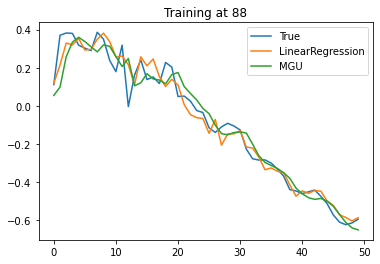

In [239]:
yMGU = yhat
print('MGU MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yMGU.detach().numpy())
plt.legend(['True','LinearRegression', 'MGU'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [240]:
#GRU
class GRUCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(GRUCell, self).__init__()
        self.rnn = nn.GRUCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [241]:
model = GRUCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [242]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'GRUCell Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

GRUCell Epoch:1 with Loss:0.21195277571678162
GRUCell Epoch:101 with Loss:0.06208828091621399
GRUCell Epoch:201 with Loss:0.010192520916461945
GRUCell Epoch:301 with Loss:0.008576519787311554
GRUCell Epoch:401 with Loss:0.008011865429580212
GRUCell Epoch:501 with Loss:0.007677324581891298
GRUCell Epoch:601 with Loss:0.007232895120978355
GRUCell Epoch:701 with Loss:0.005865960847586393
GRUCell Epoch:801 with Loss:0.004914877470582724
GRUCell Epoch:901 with Loss:0.004748816601932049


GRUCell MSE: 0.004886855371296406


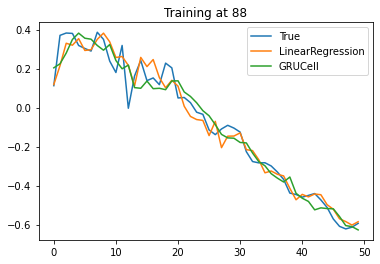

In [243]:
yGRU = yhat
print('GRUCell MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.legend(['True','LinearRegression', 'GRUCell'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [244]:
#2-layer GRU
class GRU(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(inputsize, hiddensize, 2)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(2, batchsize, hiddensize)
        output, _ = self.rnn(X2, hx)
        return self.layer2(output[seqlen - 1])[:, 0]

In [245]:
model = GRU(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [246]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'GRU Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

GRU Epoch:1 with Loss:0.09449715912342072
GRU Epoch:101 with Loss:0.012434243224561214
GRU Epoch:201 with Loss:0.008907466195523739
GRU Epoch:301 with Loss:0.006849511060863733
GRU Epoch:401 with Loss:0.006437995936721563
GRU Epoch:501 with Loss:0.0057552228681743145
GRU Epoch:601 with Loss:0.005001019686460495
GRU Epoch:701 with Loss:0.004816808272153139
GRU Epoch:801 with Loss:0.004609695170074701
GRU Epoch:901 with Loss:0.004545282572507858


GRU MSE: 0.00415530102327466


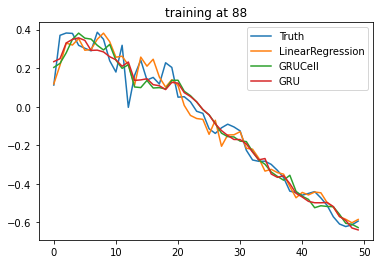

In [247]:
yGRU2 = yhat
print('GRU MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yGRU2.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRUCell', 'GRU'])
plt.title('training at ' + str(trainbegin))
plt.show()

In [248]:
#RNNCell
class RNNCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNNCell, self).__init__()
        self.rnn = nn.RNNCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [249]:
model = RNNCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [250]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'RNNCell Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

RNNCell Epoch:1 with Loss:0.6652789115905762
RNNCell Epoch:101 with Loss:0.07410579919815063
RNNCell Epoch:201 with Loss:0.01804058812558651
RNNCell Epoch:301 with Loss:0.010890569537878036
RNNCell Epoch:401 with Loss:0.009607884101569653
RNNCell Epoch:501 with Loss:0.009012042544782162
RNNCell Epoch:601 with Loss:0.008621362037956715
RNNCell Epoch:701 with Loss:0.008310308679938316
RNNCell Epoch:801 with Loss:0.008047739043831825
RNNCell Epoch:901 with Loss:0.007790558505803347


RNNCell MSE: 0.007532764226198196


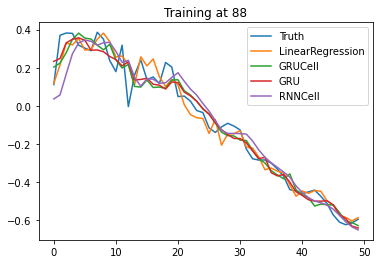

In [251]:
yRRN = yhat
print('RNNCell MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yGRU2.detach().numpy())
plt.plot(yRRN.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRUCell', 'GRU', 'RNNCell'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [252]:
#Deep 2-layer RRN model
class RNN(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(inputsize,hiddensize,2) #2-layer RNN
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn (2, batchsize , hiddensize)
        output, _ = self.rnn (X2,hx)
        return self.layer2(output[seqlen - 1])[:, 0]

In [253]:
model = RNN(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [254]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'RNN Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

RNN Epoch:1 with Loss:0.4768228530883789
RNN Epoch:101 with Loss:0.04484130069613457
RNN Epoch:201 with Loss:0.01118429284542799
RNN Epoch:301 with Loss:0.009797384031116962
RNN Epoch:401 with Loss:0.008919495157897472
RNN Epoch:501 with Loss:0.008234480395913124
RNN Epoch:601 with Loss:0.007624280638992786
RNN Epoch:701 with Loss:0.006615042220801115
RNN Epoch:801 with Loss:0.00543272215873003
RNN Epoch:901 with Loss:0.005043257959187031


RNN MSE: 0.004474893677979708


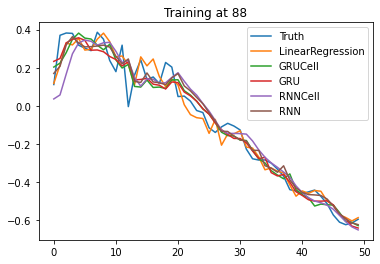

In [255]:
yRRN2 = yhat
print('RNN MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yGRU2.detach().numpy())
plt.plot(yRRN.detach().numpy())
plt.plot(yRRN2.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRUCell', 'GRU', 'RNNCell', 'RNN'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [256]:
#LSTMCell model
class LSTMCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(LSTMCell, self).__init__()
        self.rnn = nn.LSTMCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        cx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx, cx = self.rnn(X2[i], (hx, cx))
        return self.layer2(hx)[:, 0]

In [257]:
model = LSTMCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [258]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'LSTMCell Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

LSTMCell Epoch:1 with Loss:0.13914352655410767
LSTMCell Epoch:101 with Loss:0.04340219497680664
LSTMCell Epoch:201 with Loss:0.006412205286324024
LSTMCell Epoch:301 with Loss:0.005399052985012531
LSTMCell Epoch:401 with Loss:0.004176323302090168
LSTMCell Epoch:501 with Loss:0.004621978849172592
LSTMCell Epoch:601 with Loss:0.004109934438019991
LSTMCell Epoch:701 with Loss:0.003827362321317196
LSTMCell Epoch:801 with Loss:0.004519195761531591
LSTMCell Epoch:901 with Loss:0.003906621597707272


LSTMCell MSE: 0.0037400508299469948


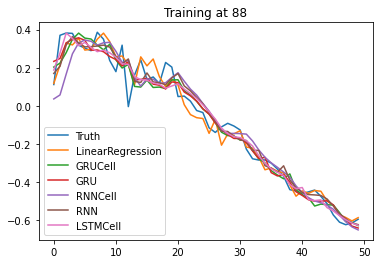

In [259]:
yLSTM = yhat
print('LSTMCell MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yGRU2.detach().numpy())
plt.plot(yRRN.detach().numpy())
plt.plot(yRRN2.detach().numpy())
plt.plot(yLSTM.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRUCell', 'GRU', 'RNNCell', 'RNN', 'LSTMCell'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [260]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(inputsize, hiddensize, 2)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(2, batchsize, hiddensize)
        cx = torch.randn(2, batchsize, hiddensize)
        output, _ = self.rnn(X2, (hx, cx))
        return self.layer2(output[seqlen - 1])[:, 0]

In [261]:
model = LSTM(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [262]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'LSTM Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

LSTM Epoch:1 with Loss:0.11034508794546127
LSTM Epoch:101 with Loss:0.023911766707897186
LSTM Epoch:201 with Loss:0.006101718172430992
LSTM Epoch:301 with Loss:0.004965648520737886
LSTM Epoch:401 with Loss:0.004327747039496899
LSTM Epoch:501 with Loss:0.004486633464694023
LSTM Epoch:601 with Loss:0.004011963494122028
LSTM Epoch:701 with Loss:0.004150363150984049
LSTM Epoch:801 with Loss:0.004169130232185125
LSTM Epoch:901 with Loss:0.00414462573826313


LSTM MSE: 0.004077848978340626


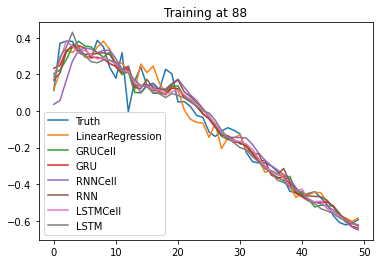

In [263]:
yLSTM2 = yhat
print('LSTM MSE:', F.mse_loss(yhat, y).item())
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yGRU2.detach().numpy())
plt.plot(yRRN.detach().numpy())
plt.plot(yRRN2.detach().numpy())
plt.plot(yLSTM.detach().numpy())
plt.plot(yLSTM2.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRUCell', 'GRU', 'RNNCell', 'RNN', 'LSTMCell','LSTM'])
plt.title('Training at ' + str(trainbegin))
plt.show()